# Data Overview
_Author : Benjamin Ternot_

## I. Importing Libraries and Global Settings

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import jaccard_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

from data_manager.datamanager import DataLoader, DataDisplayer

In [2]:
# Modifier les couleurs des textes et des axes en fonction du thème de Jupyter
DARK_BG = False

if DARK_BG:
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['axes.titlecolor'] = 'white'
else:
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'

In [3]:
PATH_SLASH = '/' if sys.platform == 'linux' else '\\'

In [4]:
# Define the root data folder
root_data_folder = f".{PATH_SLASH}database"

# Define the sub path to the folders containing the data
data_sub_folders = {
    "train": "training",
    "test": "testing",
}

# Define the mapping from group labels to diagnostic classes
group_map = {
    "NOR": "Healthy control",
    "MINF": "Myocardial infarction",
    "DCM": "Dilated cardiomyopathy",
    "HCM": "Hypertrophic cardiomyopathy",
    "RV": "Abnormal right ventricle"
}

## II. Data Loading and Displaying

In [5]:
# Create a DataLoader instance
data_loader = DataLoader(root_data_folder)

# Load the data
for key, sub_folder in data_sub_folders.items():
    data_loader.load_data(sub_folder, name=key, store=True)


Loading data in './database/training':   0%|          | 0/100 [00:00<?, ?it/s]

Loading data in './database/testing':   0%|          | 0/50 [00:00<?, ?it/s]

##########################################################################################
test data :
	------------------------------------------------------------
	Dilated cardiomyopathy :		
		
			ID: patient131, height: 164.0cm, weight: 64.0kg, group: DCM, nb_frames: 25


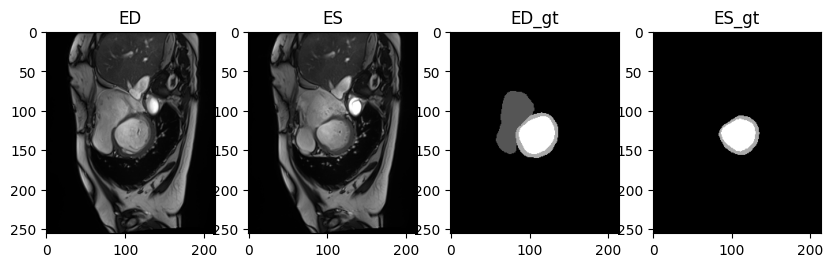

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient138, height: 174.0cm, weight: 90.0kg, group: HCM, nb_frames: 30


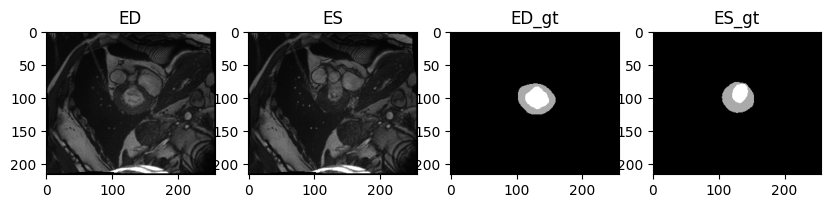

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient118, height: 176.0cm, weight: 80.0kg, group: MINF, nb_frames: 25


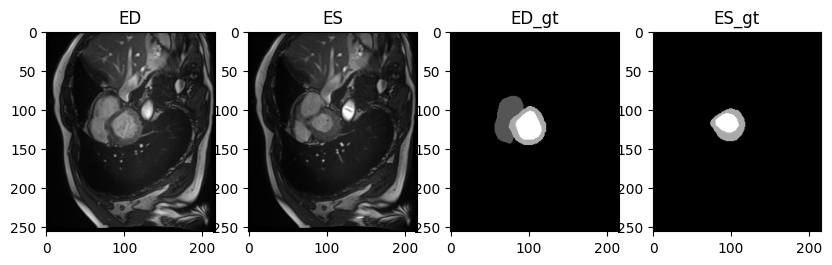

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient102, height: 156.0cm, weight: 75.0kg, group: NOR, nb_frames: 30


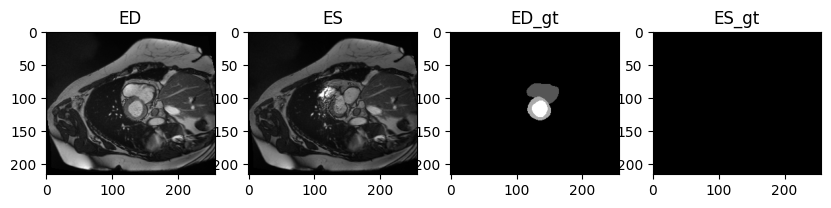

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient124, height: 174.0cm, weight: 64.0kg, group: RV, nb_frames: 15


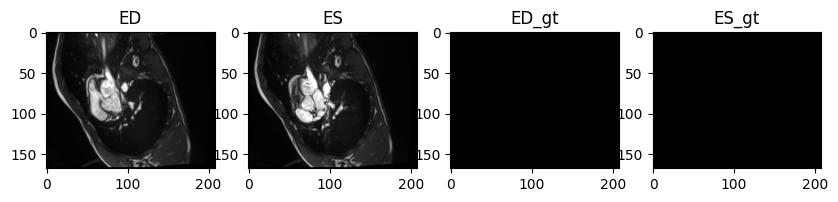

##########################################################################################
train data :
	------------------------------------------------------------
	Dilated cardiomyopathy :		
		
			ID: patient008, height: 180.0cm, weight: 100.0kg, group: DCM, nb_frames: 28


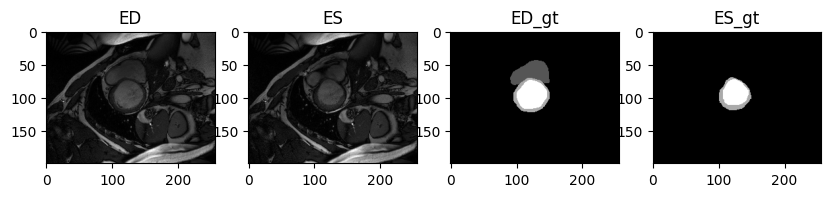

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient021, height: 192.0cm, weight: 110.0kg, group: HCM, nb_frames: 30


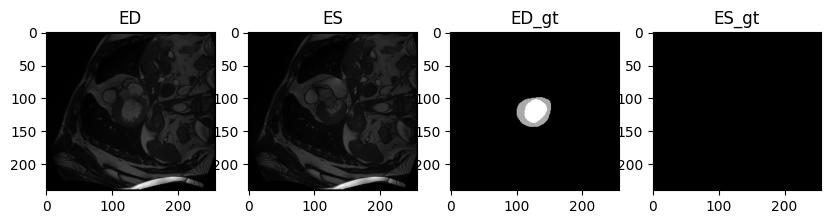

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient057, height: 175.0cm, weight: 80.0kg, group: MINF, nb_frames: 25


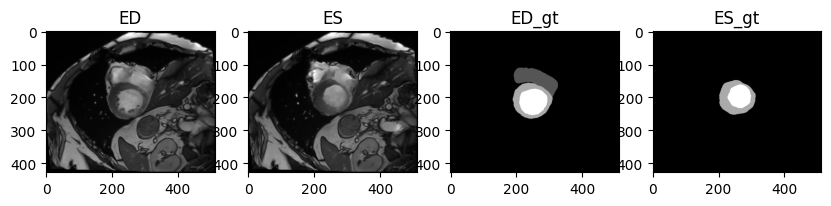

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient075, height: 179.0cm, weight: 93.0kg, group: NOR, nb_frames: 14


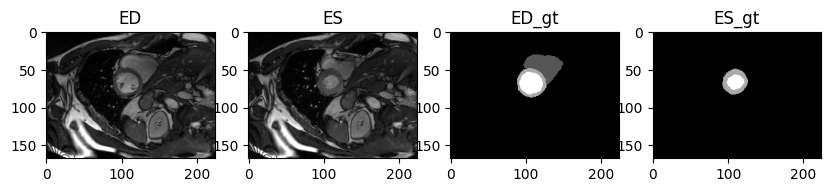

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient098, height: 167.0cm, weight: 50.0kg, group: RV, nb_frames: 22


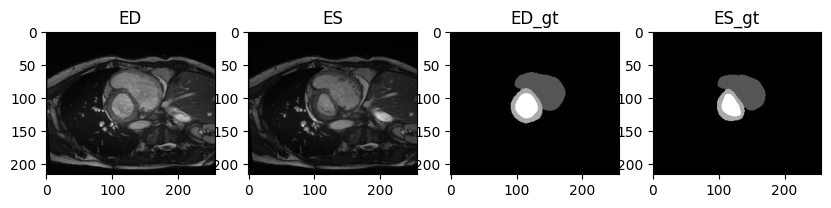

In [6]:
# Initialize the DataDisplayer with the DataLoader instance
data_displayer = DataDisplayer(data_loader, group_map=group_map)

# Display some examples
data_displayer.display_examples(nb_examples=1, per_combination=True, sort_by=('data_name', 'group', 'id'), format_sep=('#' * 90, '-' * 60, ''), format_categories=('{} data :\n', '{} :', '\n'))

In [7]:
# Display as an arborescence the dataloader.data dictionary
data_displayer.display_data_arborescence('data_loader.data', max_keys=2)

data_loader.data
├── train
│	├── patient093
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ...
│	│	├── height
│	│	├── ...
│	├── patient077
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ...
│	│	├── height
│	│	├── ...
│	├── ...
├── test
│	├── patient125
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ...
│	│	├── height
│	│	├── ...
│	├── patient117
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ...
│	│	├── height
│	│	├── ...
│	├── ...


## III. Data Overview

There are 74 different shapes in the data
X axis varies from 154 to 428
Y axis varies from 154 to 512
Z axis varies from 6 to 21
Aspect ratio (X/Y) varies from 0.6388888888888888 to 1.4545454545454546


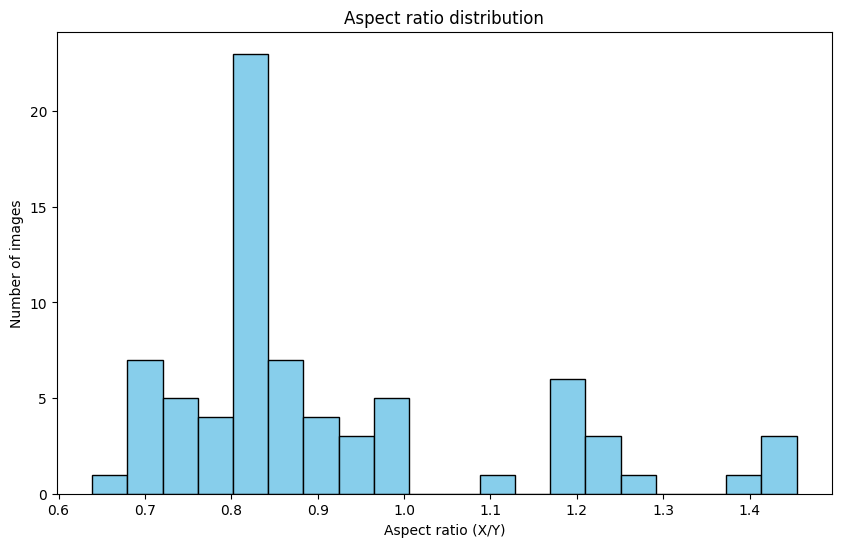

In [8]:
# Show repartition of shape of the images
shape_dict = {}
for dataset_key, dataset in data_loader.data.items():
    for patient, patient_data in dataset.items():
        for image_name, image in patient_data['image_data'].items(): 
            shape = image.shape
            if shape not in shape_dict:
                shape_dict[shape] = 1
            else:
                shape_dict[shape] += 1
                
print(
    f'There are {len(shape_dict)} different shapes in the data'
    f'\nX axis varies from {min([shape[0] for shape in shape_dict.keys()])} to {max([shape[0] for shape in shape_dict.keys()])}'
    f'\nY axis varies from {min([shape[1] for shape in shape_dict.keys()])} to {max([shape[1] for shape in shape_dict.keys()])}'
    f'\nZ axis varies from {min([shape[2] for shape in shape_dict.keys()])} to {max([shape[2] for shape in shape_dict.keys()])}'
    f'\nAspect ratio (X/Y) varies from {min([shape[0] / shape[1] for shape in shape_dict.keys()])} to {max([shape[0] / shape[1] for shape in shape_dict.keys()])}'
)
# plot the repartition of the aspect ratio
plt.figure(figsize=(10, 6))
plt.hist([shape[0] / shape[1] for shape in shape_dict.keys()], bins=20, color='skyblue', edgecolor='black')
plt.title('Aspect ratio distribution')
plt.xlabel('Aspect ratio (X/Y)')
plt.ylabel('Number of images')
plt.show()

In [9]:
# Reshape the images to the same shape
shape_resized = data_loader.standardize_images()
print(f'Shape after resizing all images: {shape_resized[0]} x {shape_resized[1]} x {shape_resized[2]}')

Standardizing images in 'train':   0%|          | 0/100 [00:00<?, ?it/s]

Standardizing images in 'test':   0%|          | 0/50 [00:00<?, ?it/s]

Shape after resizing all images: 512 x 428 x 21


## IV. Simple Model

In [10]:
# Create a simple diffusion model to create binary masks from the images
class SimpleDiffusionModel(nn.Module):
    def __init__(self):
        super(SimpleDiffusionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=(3, 3, 1), padding=1),
            nn.MaxPool3d(2),
            nn.LeakyReLU(),
            nn.Conv3d(64, 128, kernel_size=(3, 3, 1), padding=1),
            nn.MaxPool3d(2),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=(2, 2, 1), stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose3d(64, 1, kernel_size=(2, 2, 1), stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = SimpleDiffusionModel()
print(model)
       

SimpleDiffusionModel(
  (encoder): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(64, 128, kernel_size=(3, 3, 1), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): ConvTranspose3d(128, 64, kernel_size=(2, 2, 1), stride=(2, 2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose3d(64, 1, kernel_size=(2, 2, 1), stride=(2, 2, 2))
    (3): Sigmoid()
  )
)


In [11]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a jaccard loss (IoU), ideal for mask shapes
def jaccard_loss(outputs, targets, smooth=1e-6):
    intersection = (outputs * targets).sum()
    union = outputs.sum() + targets.sum() - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return 1 - jaccard

# Initialize the model, loss function, and optimizer
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Create input and labels sets
def create_datasets(data_loader):
    train_images = []
    train_masks = []
    test_images = []
    test_masks = []
    for dataset_key, dataset in data_loader.data.items():
        for patient, patient_data in tqdm(dataset.items(), desc=f"Creating the '{dataset_key}' set"):
            for image_name, image in patient_data['image_data_resized'].items():
                if 'gt' not in image_name:
                    mask_name = f'{image_name}_gt'
                    if mask_name in patient_data['image_data_resized']:
                        mask = patient_data['image_data_resized'][mask_name]
                        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dimensions
                        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dimensions
                        if dataset_key == 'train':
                            train_images.append(image_tensor)
                            train_masks.append(mask_tensor)
                        elif dataset_key == 'test':
                            test_images.append(image_tensor)
                            test_masks.append(mask_tensor)
    train_images = torch.cat(train_images)
    train_masks = torch.cat(train_masks)
    test_images = torch.cat(test_images)
    test_masks = torch.cat(test_masks)
    return train_images, train_masks, test_images, test_masks

train_images, train_masks, test_images, test_masks = create_datasets(data_loader)

Creating the 'train' set:   0%|          | 0/100 [00:00<?, ?it/s]

Creating the 'test' set:   0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
# Training loop
num_epochs = 100
test_losses = [0.]*num_epochs
train_losses = [0.]*num_epochs
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    model.train()
    running_train_loss = 0.0
    for i in tqdm(range(train_images.size(0)), desc=f'Training loop, epoch {epoch+1}'):
        image, mask = train_images[i], train_masks[i]
        optimizer.zero_grad()
        outputs = model(image)
        loss = jaccard_loss(outputs, mask)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    train_losses[epoch-1] = running_train_loss
    running_test_loss = 0.0
    with torch.no_grad():
        for i in tqdm(range(test_images.size(0)), desc=f'Testing loop, epoch {epoch+1}'):
            image, mask = test_images[i], test_masks[i]
            outputs = model(image)
            loss = jaccard_loss(outputs, mask)
            running_test_loss += loss.item()
        test_losses[epoch] = running_test_loss
    print(f'\t* Loss : \n\t\t -train: {running_train_loss:.2f}\n\t\t -test: {running_test_loss:.2f}')

Epoch [1/100]


Training loop, epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 197.76
		 -test: 98.79
Epoch [2/100]


Training loop, epoch 2:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 197.61
		 -test: 98.73
Epoch [3/100]


Training loop, epoch 3:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 197.37
		 -test: 98.60
Epoch [4/100]


Training loop, epoch 4:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 197.19
		 -test: 98.51
Epoch [5/100]


Training loop, epoch 5:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 196.99
		 -test: 98.39
Epoch [6/100]


Training loop, epoch 6:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 196.74
		 -test: 98.25
Epoch [7/100]


Training loop, epoch 7:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 196.43
		 -test: 98.07
Epoch [8/100]


Training loop, epoch 8:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 196.01
		 -test: 97.82
Epoch [9/100]


Training loop, epoch 9:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 195.48
		 -test: 97.51
Epoch [10/100]


Training loop, epoch 10:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 194.88
		 -test: 97.25
Epoch [11/100]


Training loop, epoch 11:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 194.21
		 -test: 96.86
Epoch [12/100]


Training loop, epoch 12:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 193.47
		 -test: 96.63
Epoch [13/100]


Training loop, epoch 13:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 192.80
		 -test: 96.18
Epoch [14/100]


Training loop, epoch 14:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 191.99
		 -test: 95.79
Epoch [15/100]


Training loop, epoch 15:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 191.15
		 -test: 95.59
Epoch [16/100]


Training loop, epoch 16:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 190.54
		 -test: 95.14
Epoch [17/100]


Training loop, epoch 17:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 189.56
		 -test: 94.89
Epoch [18/100]


Training loop, epoch 18:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 188.83
		 -test: 94.37
Epoch [19/100]


Training loop, epoch 19:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 188.38
		 -test: 94.49
Epoch [20/100]


Training loop, epoch 20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 187.85
		 -test: 93.25
Epoch [21/100]


Training loop, epoch 21:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 21:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 187.26
		 -test: 94.00
Epoch [22/100]


Training loop, epoch 22:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 22:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 186.05
		 -test: 92.11
Epoch [23/100]


Training loop, epoch 23:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 23:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 184.30
		 -test: 92.28
Epoch [24/100]


Training loop, epoch 24:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 24:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 183.60
		 -test: 91.37
Epoch [25/100]


Training loop, epoch 25:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 25:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 182.78
		 -test: 90.92
Epoch [26/100]


Training loop, epoch 26:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 26:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 182.10
		 -test: 91.08
Epoch [27/100]


Training loop, epoch 27:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 27:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 181.43
		 -test: 90.24
Epoch [28/100]


Training loop, epoch 28:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 28:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 181.15
		 -test: 90.66
Epoch [29/100]


Training loop, epoch 29:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 29:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 180.41
		 -test: 88.99
Epoch [30/100]


Training loop, epoch 30:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 30:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 177.98
		 -test: 88.57
Epoch [31/100]


Training loop, epoch 31:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 31:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 178.06
		 -test: 89.35
Epoch [32/100]


Training loop, epoch 32:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 32:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 177.36
		 -test: 87.85
Epoch [33/100]


Training loop, epoch 33:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 33:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 176.65
		 -test: 88.11
Epoch [34/100]


Training loop, epoch 34:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 34:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 176.00
		 -test: 87.81
Epoch [35/100]


Training loop, epoch 35:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 35:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 175.89
		 -test: 87.98
Epoch [36/100]


Training loop, epoch 36:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 36:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 175.76
		 -test: 87.64
Epoch [37/100]


Training loop, epoch 37:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 37:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 175.02
		 -test: 87.83
Epoch [38/100]


Training loop, epoch 38:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 38:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 175.17
		 -test: 87.62
Epoch [39/100]


Training loop, epoch 39:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 39:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 173.33
		 -test: 85.92
Epoch [40/100]


Training loop, epoch 40:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 40:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 171.74
		 -test: 85.87
Epoch [41/100]


Training loop, epoch 41:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 41:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 171.12
		 -test: 86.06
Epoch [42/100]


Training loop, epoch 42:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 42:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 170.79
		 -test: 85.69
Epoch [43/100]


Training loop, epoch 43:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 43:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 170.25
		 -test: 85.47
Epoch [44/100]


Training loop, epoch 44:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 44:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 169.97
		 -test: 85.27
Epoch [45/100]


Training loop, epoch 45:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 45:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 169.99
		 -test: 85.30
Epoch [46/100]


Training loop, epoch 46:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 46:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 169.73
		 -test: 85.17
Epoch [47/100]


Training loop, epoch 47:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 47:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 169.76
		 -test: 85.18
Epoch [48/100]


Training loop, epoch 48:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 48:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 169.30
		 -test: 85.16
Epoch [49/100]


Training loop, epoch 49:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 49:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 168.76
		 -test: 85.06
Epoch [50/100]


Training loop, epoch 50:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 50:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 168.83
		 -test: 85.45
Epoch [51/100]


Training loop, epoch 51:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 51:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 168.92
		 -test: 85.13
Epoch [52/100]


Training loop, epoch 52:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 52:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 168.16
		 -test: 84.86
Epoch [53/100]


Training loop, epoch 53:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 53:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 168.21
		 -test: 84.90
Epoch [54/100]


Training loop, epoch 54:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 54:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 167.96
		 -test: 84.88
Epoch [55/100]


Training loop, epoch 55:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 55:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 167.58
		 -test: 84.75
Epoch [56/100]


Training loop, epoch 56:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 56:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 167.85
		 -test: 84.70
Epoch [57/100]


Training loop, epoch 57:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 57:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 167.41
		 -test: 84.55
Epoch [58/100]


Training loop, epoch 58:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 58:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 167.20
		 -test: 84.55
Epoch [59/100]


Training loop, epoch 59:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 59:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 167.04
		 -test: 84.61
Epoch [60/100]


Training loop, epoch 60:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 60:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 167.38
		 -test: 84.39
Epoch [61/100]


Training loop, epoch 61:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 61:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 166.50
		 -test: 84.36
Epoch [62/100]


Training loop, epoch 62:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 62:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 166.74
		 -test: 84.47
Epoch [63/100]


Training loop, epoch 63:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 63:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 166.21
		 -test: 84.25
Epoch [64/100]


Training loop, epoch 64:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 64:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 166.99
		 -test: 84.46
Epoch [65/100]


Training loop, epoch 65:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 65:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 166.36
		 -test: 84.15
Epoch [66/100]


Training loop, epoch 66:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 66:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 166.50
		 -test: 84.16
Epoch [67/100]


Training loop, epoch 67:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 67:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 165.93
		 -test: 84.14
Epoch [68/100]


Training loop, epoch 68:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 68:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 166.00
		 -test: 84.25
Epoch [69/100]


Training loop, epoch 69:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 69:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 166.05
		 -test: 84.14
Epoch [70/100]


Training loop, epoch 70:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 70:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 165.76
		 -test: 84.23
Epoch [71/100]


Training loop, epoch 71:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 71:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 165.36
		 -test: 84.16
Epoch [72/100]


Training loop, epoch 72:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 72:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 165.47
		 -test: 83.93
Epoch [73/100]


Training loop, epoch 73:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 73:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 165.55
		 -test: 84.22
Epoch [74/100]


Training loop, epoch 74:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 74:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 165.37
		 -test: 83.89
Epoch [75/100]


Training loop, epoch 75:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 75:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 165.11
		 -test: 83.91
Epoch [76/100]


Training loop, epoch 76:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 76:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 165.23
		 -test: 83.84
Epoch [77/100]


Training loop, epoch 77:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 77:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 165.22
		 -test: 84.01
Epoch [78/100]


Training loop, epoch 78:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 78:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 165.31
		 -test: 84.02
Epoch [79/100]


Training loop, epoch 79:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 79:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.87
		 -test: 83.79
Epoch [80/100]


Training loop, epoch 80:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 80:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.83
		 -test: 83.89
Epoch [81/100]


Training loop, epoch 81:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 81:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.63
		 -test: 83.71
Epoch [82/100]


Training loop, epoch 82:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 82:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.58
		 -test: 84.04
Epoch [83/100]


Training loop, epoch 83:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 83:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.91
		 -test: 83.79
Epoch [84/100]


Training loop, epoch 84:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 84:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.78
		 -test: 83.90
Epoch [85/100]


Training loop, epoch 85:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 85:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.52
		 -test: 83.98
Epoch [86/100]


Training loop, epoch 86:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 86:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.31
		 -test: 83.83
Epoch [87/100]


Training loop, epoch 87:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 87:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.10
		 -test: 83.85
Epoch [88/100]


Training loop, epoch 88:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 88:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.85
		 -test: 83.71
Epoch [89/100]


Training loop, epoch 89:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 89:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.25
		 -test: 83.81
Epoch [90/100]


Training loop, epoch 90:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 90:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.09
		 -test: 83.76
Epoch [91/100]


Training loop, epoch 91:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 91:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.03
		 -test: 83.80
Epoch [92/100]


Training loop, epoch 92:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 92:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 163.81
		 -test: 83.78
Epoch [93/100]


Training loop, epoch 93:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 93:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 164.11
		 -test: 83.78
Epoch [94/100]


Training loop, epoch 94:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 94:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 163.73
		 -test: 83.91
Epoch [95/100]


Training loop, epoch 95:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 95:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 163.78
		 -test: 83.90
Epoch [96/100]


Training loop, epoch 96:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 96:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 163.64
		 -test: 83.75
Epoch [97/100]


Training loop, epoch 97:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 97:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 163.39
		 -test: 83.83
Epoch [98/100]


Training loop, epoch 98:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 98:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 163.71
		 -test: 83.96
Epoch [99/100]


Training loop, epoch 99:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 99:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 163.54
		 -test: 83.82
Epoch [100/100]


Training loop, epoch 100:   0%|          | 0/200 [00:00<?, ?it/s]

Testing loop, epoch 100:   0%|          | 0/100 [00:00<?, ?it/s]

	* Loss : 
		 -train: 163.44
		 -test: 83.94
